<a href="https://colab.research.google.com/github/gagankaushal/CancerDetection/blob/master/CancerDetection_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.imports import *

# Import Libraries here
import os
import json 
import shutil
import zipfile

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Setting the path
root_dir = "/home/kaushal/"

# notebook project directories
base_dir = root_dir + 'ml/pcam/'
!mkdir -p "{base_dir}"

In [0]:
# set the random seed
np.random.seed(2)

In [3]:
# First we make sure we have the kaggle sdk installed.
# We assume here that on your machine you have the kaggle.json token file in ~/.kaggle/
!pip install kaggle

In [18]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"gagankaushal","key":"b6ee02d1b53b8723e20b5ba45060659a"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [22]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [24]:
# Can list available Kaggle competitions here if needed
# !kaggle competitions list

# Download the histopathological data
!kaggle competitions download -c histopathologic-cancer-detection -p "{base_dir}"

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 87.6MB/s]
 98% 5.00M/5.10M [00:00<00:00, 26.3MB/s]
100% 5.10M/5.10M [00:00<00:00, 24.9MB/s]
 99% 1.30G/1.30G [00:20<00:00, 66.3MB/s]
100% 1.30G/1.30G [00:20<00:00, 68.3MB/s]
100% 4.97G/4.98G [01:15<00:00, 64.0MB/s]
100% 4.98G/4.98G [01:15<00:00, 71.1MB/s]


In [25]:
#now unzip the training files
!mkdir -p "{base_dir}train/"
dest_dir_train = Path(base_dir + 'train/')
print(base_dir + 'train.zip')
train_zip = zipfile.ZipFile(base_dir + 'train.zip', 'r')
train_zip.extractall(dest_dir_train)
train_zip.close()

/home/kaushal/ml/pcam/train.zip


In [0]:
#now unzip the test files
!mkdir -p "{base_dir}test/"
dest_dir_test = Path(base_dir + 'test/')
test_zip = zipfile.ZipFile(base_dir + 'test.zip', 'r')
test_zip.extractall(dest_dir_test)
test_zip.close()

In [0]:
dest_dir_csv = Path(base_dir)
labels_csv_zip = zipfile.ZipFile(base_dir + 'train_labels.csv.zip', 'r')
labels_csv_zip.extractall(dest_dir_csv)
labels_csv_zip.close()

In [31]:
# Check the download here
path = Path(base_dir)
path.ls()

[PosixPath('/home/kaushal/ml/pcam/train_labels.csv'),
 PosixPath('/home/kaushal/ml/pcam/train'),
 PosixPath('/home/kaushal/ml/pcam/test'),
 PosixPath('/home/kaushal/ml/pcam/train_labels.csv.zip'),
 PosixPath('/home/kaushal/ml/pcam/test.zip'),
 PosixPath('/home/kaushal/ml/pcam/sample_submission.csv.zip'),
 PosixPath('/home/kaushal/ml/pcam/train.zip')]

In [0]:
tfms = get_transforms(do_flip=True)

In [0]:
bs=64 # also the default batch size
data = ImageDataBunch.from_csv(
    base_dir, 
    ds_tfms=tfms, 
    size=224, 
    suffix=".tif",
    folder="train", 
    test="test",
    csv_labels="train_labels.csv", 
    bs=bs)

In [31]:
# now normalise the images
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,0,1,1
Path: /home/kaushal/ml/pcam;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,1
Path: /home/kaushal/ml/pcam;

Test: LabelList (57458 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/kaushal/ml/pcam

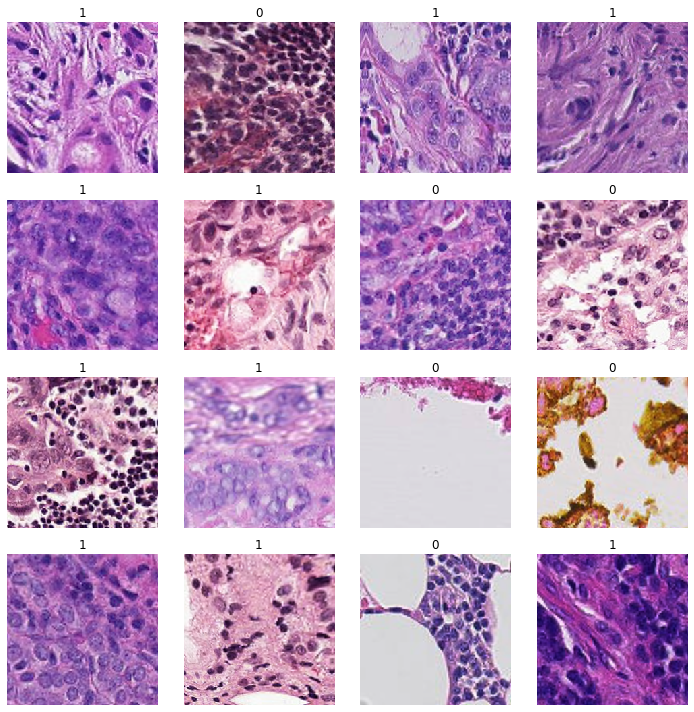

In [35]:
data.show_batch(rows=4, figsize=(10, 10))

In [32]:
# I am using a GPU that supports 16bit precision, so we also switch this support mode to on. 
# If your GPU does not have that support you can omit the to_fp16() call
learn = cnn_learner(data, models.densenet121, metrics=error_rate, callback_fns=ShowGraph).to_fp16()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 94.9MB/s]


In [33]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


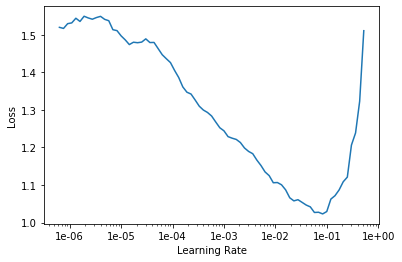

In [34]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.158757,0.124367,0.043654,24:20


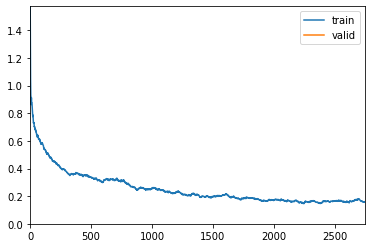

In [35]:
learn.fit_one_cycle(1, slice(1e-02))

In [0]:
learn.save(base_dir + 'pcamv4-stage-1')

In [37]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

The accuracy is 95.63458251953125 %.


In [38]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

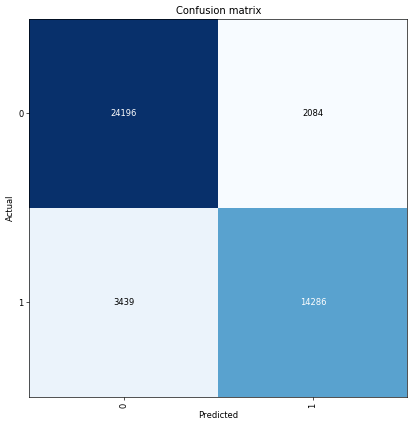

In [48]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

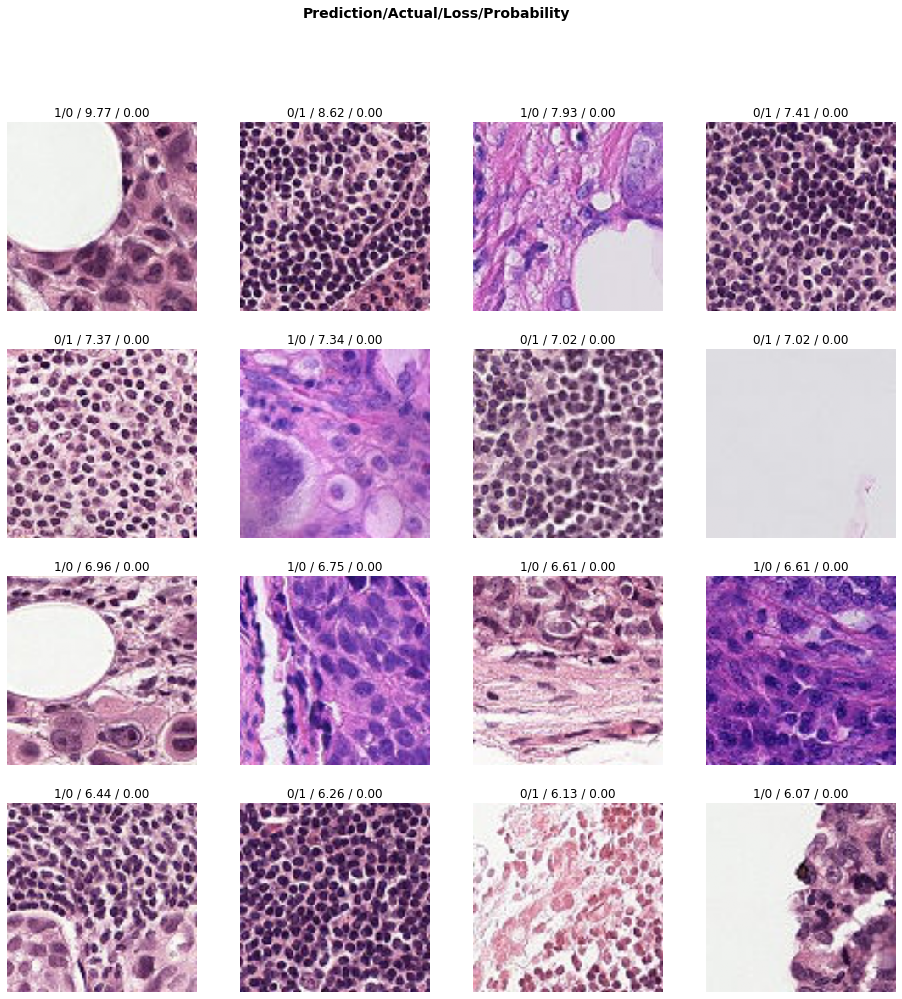

In [39]:
interp.plot_top_losses(16, figsize=(16,16))

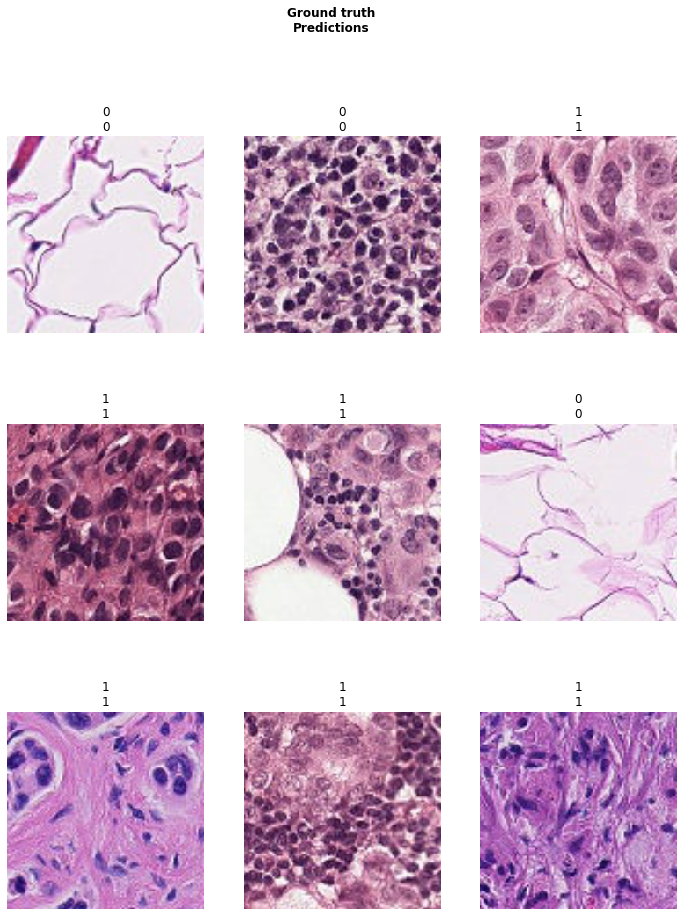

In [40]:
learn.show_results(rows=3, figsize=(12,15))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


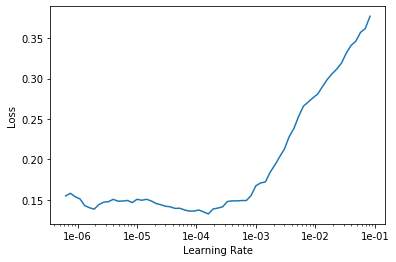

In [41]:
# Using the plot from the learning rate finder above, 
# find a value for the first value in the max_lr slice 
# that is well before the point when the loss start to significantly degrade
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.132070,0.105024,0.036110,25:55


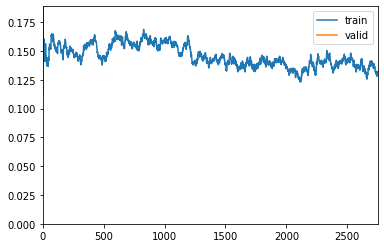

In [42]:

learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-4))

In [43]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

The accuracy is 96.38904571533203 %.
